# Modelagem do dataset transacional

Transformação do dataset transacional em um dataset agrupado com objetivo de analisar as transações dentro de uma janela de tempo

## Biblitecas

Bibliotecas utilizadas para o processo

In [1]:
%pip install openai -q -U

In [2]:
import os
import json
import shutil
import openai
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
azure_client: openai.AzureOpenAI|None = None
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  from google.colab import userdata

  azure_client = openai.AzureOpenAI(
      azure_endpoint=userdata.get('AZURE_OPENAI_ENDPOINT'),
      api_version=userdata.get('OPENAI_API_VERSION'),
      api_key=userdata.get('AZURE_OPENAI_API_KEY'),
  )

  os.makedirs('./datasets', exist_ok=True)
  drive.mount('/content/drive')

  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_train_test.parquet','/content/datasets/')
  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_validation.parquet','/content/datasets/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Carregamento de dados e ajuste de dados/valores

In [4]:
df = pl.concat([pl.read_parquet('./datasets/df_train_test.parquet'), pl.read_parquet('./datasets/df_validation.parquet')])
df.head()

id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,description,target,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
i64,datetime[ns],i64,i64,f64,str,i64,str,str,f64,str,str,str,str,i64,i64,i64,i64,str,str,f64,f64,f64,f64,f64,i64,i64,str,str,i64,str,i64,str,i64,f64,str,i64,str
7475327,2010-01-01 00:01:00,1556,2972,-77.0,"""Swipe Transaction""",59935,"""Beulah""","""ND""",58523.0,"""5499""",null,"""Miscellaneous Food Stores""","""No""",30,67,1989,7,"""Female""","""594 Mountain View Street""",46.8,-100.76,23679.0,48277.0,110153.0,740,4,"""Mastercard""","""Debit (Prepaid)""",5497590243197280,"""07/2022""",306,"""YES""",2,55.0,"""05/2008""",2008,"""No"""
7475328,2010-01-01 00:02:00,561,4575,14.57,"""Swipe Transaction""",67570,"""Bettendorf""","""IA""",52722.0,"""5311""",null,"""Department Stores""","""No""",48,67,1971,6,"""Male""","""604 Pine Street""",40.8,-91.12,18076.0,36853.0,112139.0,834,5,"""Mastercard""","""Credit""",5175842699412235,"""12/2024""",438,"""YES""",1,9100.0,"""09/2005""",2015,"""No"""
7475329,2010-01-01 00:02:00,1129,102,80.0,"""Swipe Transaction""",27092,"""Vista""","""CA""",92084.0,"""4829""",null,"""Money Transfer""","""No""",49,65,1970,4,"""Male""","""2379 Forest Lane""",33.18,-117.29,16894.0,34449.0,36540.0,686,3,"""Mastercard""","""Debit""",5874992802287595,"""05/2020""",256,"""YES""",1,14802.0,"""01/2006""",2008,"""No"""
7475332,2010-01-01 00:06:00,848,3915,46.41,"""Swipe Transaction""",13051,"""Harwood""","""MD""",20776.0,"""5813""",null,"""Drinking Places (Alcoholic Bev…","""No""",51,69,1968,5,"""Male""","""166 River Drive""",38.86,-76.6,33529.0,68362.0,96182.0,711,2,"""Visa""","""Debit""",4354185735186651,"""01/2020""",120,"""YES""",1,19113.0,"""07/2009""",2014,"""No"""
7475333,2010-01-01 00:07:00,1807,165,4.81,"""Swipe Transaction""",20519,"""Bronx""","""NY""",10464.0,"""5942""",null,"""Book Stores""","""No""",47,65,1972,12,"""Female""","""14780 Plum Lane""",40.84,-73.87,25537.0,52065.0,98613.0,828,5,"""Mastercard""","""Debit (Prepaid)""",5207231566469664,"""03/2014""",198,"""YES""",1,89.0,"""01/2008""",2015,"""No"""


In [5]:
df = df.with_columns(
    pl.when(pl.col('merchant_city').str.to_lowercase() == 'online')
    .then(pl.lit('Yes'))
    .otherwise(pl.lit('No'))
    .alias('online_sales')
).with_columns(
    pl.when(pl.col('merchant_city').str.to_lowercase() == 'online')
    .then(pl.lit('Online'))
    .otherwise(pl.col('merchant_city'))
    .alias('city')
).with_columns(
    pl.when(pl.col('merchant_state').str.len_chars() == 2)
    .then(pl.lit('United States'))
    .otherwise(pl.col('merchant_state'))
    .alias('country')
    .fill_null('Online')
)
df.sample(5)

id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,description,target,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web,online_sales,city,country
i64,datetime[ns],i64,i64,f64,str,i64,str,str,f64,str,str,str,str,i64,i64,i64,i64,str,str,f64,f64,f64,f64,f64,i64,i64,str,str,i64,str,i64,str,i64,f64,str,i64,str,str,str,str
9315826,2011-03-24 12:44:00,1727,5982,86.0,"""Swipe Transaction""",59935,"""Columbia""","""SC""",29229.0,"""5499""",null,"""Miscellaneous Food Stores""","""No""",46,67,1973,10,"""Female""","""31 Oak Avenue""",34.0,-81.03,23917.0,48762.0,143208.0,771,6,"""Visa""","""Debit""",4475380884726150,"""06/2024""",972,"""YES""",1,24230.0,"""12/2009""",2011,"""No""","""No""","""Columbia""","""United States"""
19804625,2017-07-15 12:06:00,989,4124,91.0,"""Chip Transaction""",61195,"""Chantilly""","""VA""",20152.0,"""5541""",null,"""Service Stations""","""No""",78,66,1941,9,"""Male""","""6283 Rose Avenue""",38.87,-77.4,46175.0,113514.0,16524.0,727,8,"""Visa""","""Credit""",4119849353170305,"""02/2020""",170,"""YES""",2,21600.0,"""08/2003""",2015,"""No""","""No""","""Chantilly""","""United States"""
17524274,2016-03-17 07:50:00,855,5715,2.24,"""Swipe Transaction""",50072,"""Jackson""","""MS""",39213.0,"""5912""",null,"""Drug Stores and Pharmacies""","""No""",51,65,1969,1,"""Male""","""1047 Seventh Street""",32.32,-90.2,11061.0,22557.0,63019.0,699,5,"""Visa""","""Debit""",4118028917520417,"""03/2022""",471,"""YES""",2,11928.0,"""11/2015""",2015,"""No""","""No""","""Jackson""","""United States"""
12991286,2013-07-07 10:22:00,1168,3239,76.07,"""Swipe Transaction""",59935,"""Dallas""","""TX""",75211.0,"""5499""",null,"""Miscellaneous Food Stores""","""No""",51,68,1968,10,"""Male""","""207 Ocean View Street""",40.67,-74.42,53790.0,109673.0,242379.0,505,1,"""Mastercard""","""Debit""",5809446324429038,"""09/2020""",480,"""YES""",1,25422.0,"""06/2002""",2008,"""No""","""No""","""Dallas""","""United States"""
11164029,2012-05-23 17:57:00,441,5223,89.99,"""Swipe Transaction""",20561,"""Woodstock""","""GA""",30188.0,"""5912""",null,"""Drug Stores and Pharmacies""","""No""",41,64,1978,6,"""Female""","""608 Washington Drive""",33.65,-84.86,22613.0,46108.0,64994.0,635,1,"""Visa""","""Debit""",4135867565103066,"""12/2024""",486,"""YES""",1,21087.0,"""10/2010""",2016,"""No""","""No""","""Woodstock""","""United States"""


## Conversão do dataset em um dataset agrupado

Utilizando uma janela de tempo de 15 min para agrupar os dados.

Features aplicadas para os tipos de dados:

> Totais

Utilização do total de transações existentes no grupo e quantidade de fraudes existentes nesse grupo.

> Variaveis numéricas

Utilização das estatisticas abaixo para obter o comportamento desses dados para o grupo:

* Média: Medida de centralidade dos dados
* Desvio padrão: Média de dispersão dos dados
* Assemetria: Medida de forma que identifica se a distribuição dos dados é simetrica
* Curtose: Medida de forma que identifica o achatamento da curva de distribuição dos dados


> Variáveis categoricas

Utilização do percentual de presença dessa categoria para a varial para cada registros

* Para categorias binárias, apenas uma categoristica será registrada
* Para categorias com multiplos valores, todas as categorias serão registradas. A somatória deve ser igual a 1.

In [6]:
def floor_to_15min(dt_value: datetime) -> datetime|None:
    if dt_value is None:
        return None

    seconds_since_midnight = (dt_value - dt_value.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()
    interval_seconds = 15 * 60
    floored_seconds = (seconds_since_midnight // interval_seconds) * interval_seconds
    return dt_value.replace(hour=0, minute=0, second=0, microsecond=0) + timedelta(seconds=floored_seconds)

In [7]:
df = df.with_columns(
    pl.col("date").map_elements(floor_to_15min, return_dtype=pl.Datetime).alias("date_window")
)

In [8]:
def generate_columns_statistics(column_name: str) -> list:
    return [
        pl.col(column_name).mean().alias(f'mean_{column_name}'),
        pl.col(column_name).std().alias(f'std_{column_name}'),
        pl.col(column_name).skew().alias(f'skew_{column_name}'),
        pl.col(column_name).kurtosis().alias(f'kurtosis_{column_name}')
    ]

In [9]:
df = df.with_columns(
    pl.when(pl.col('target') == 'Yes').then(1).otherwise(0).alias('target')
)

In [10]:
aggregate = [pl.col('amount').count().alias('transactions'), pl.col('target').sum().alias('frauds')]
for column in ['amount', 'current_age', 'per_capita_income', 'total_debt', 'credit_score', 'num_credit_cards', 'credit_limit']:
  aggregate.extend(generate_columns_statistics(column))

In [11]:
def list_structs_to_dict(list_of_structs, column_name):
  if list_of_structs is None:
      return None

  items = {}
  for item in list_of_structs:
    key = item[column_name]
    value = round(item['proportion'], 2)
    items[key] = value

  return items

def convert_categorical_to_percent(df: pl.DataFrame, column_name: str, group_by_column, drop_first_if_binary_class=False) -> pl.DataFrame:
  list_structs_to_dict_column = lambda items: list_structs_to_dict(items, column_name)

  df_group = df.group_by(group_by_column).agg(pl.col(column_name).value_counts(normalize=True)).sort(group_by_column)

  df_fields = df_group.with_columns(
    pl.col(column_name).map_elements(
        list_structs_to_dict_column,
        return_dtype=pl.Object
  ).alias(column_name))

  fields = df_fields[column_name].to_list()
  data = pd.DataFrame(fields).fillna(0.0)
  data.columns = [f'{column_name}_{col.lower().replace(" ", "_")}' for col in data.columns]

  if drop_first_if_binary_class and len(data.columns) == 2:
    first_column = data.columns[0]
    data = data.drop(columns=[first_column])

  data = pl.from_pandas(data)
  data = data.with_columns(df_fields[group_by_column].alias(group_by_column))
  return data

In [12]:
df_model = df.group_by('date_window').agg(
    *aggregate
).sort('date_window')
df_model.head()

date_window,transactions,frauds,mean_amount,std_amount,skew_amount,kurtosis_amount,mean_current_age,std_current_age,skew_current_age,kurtosis_current_age,mean_per_capita_income,std_per_capita_income,skew_per_capita_income,kurtosis_per_capita_income,mean_total_debt,std_total_debt,skew_total_debt,kurtosis_total_debt,mean_credit_score,std_credit_score,skew_credit_score,kurtosis_credit_score,mean_num_credit_cards,std_num_credit_cards,skew_num_credit_cards,kurtosis_num_credit_cards,mean_credit_limit,std_credit_limit,skew_credit_limit,kurtosis_credit_limit
datetime[μs],u32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2010-01-01 00:00:00,6,0,15.875,52.737742,-0.760483,-0.139116,46.833333,8.841191,-1.241314,0.444023,21897.166667,7198.264219,0.522412,-0.861983,93656.666667,28711.635012,-1.594374,0.842529,763.5,61.29845,0.001812,-1.536333,4.0,1.264911,-0.649519,-1.125,7200.833333,8439.396078,0.381076,-1.520432
2010-01-01 00:15:00,4,0,22.2625,22.245049,0.012927,-1.980469,49.5,16.663333,-0.134765,-1.560644,24534.0,1301.539345,0.354425,-1.461239,60605.5,59834.776479,-0.01997,-1.967191,724.5,24.310492,-0.830693,-0.974824,4.25,0.957427,-0.493382,-1.371901,12608.5,13718.592311,0.010111,-1.972188
2010-01-01 00:30:00,10,0,34.644,45.188942,-0.779579,0.46044,48.6,4.993329,-0.461034,0.602038,21695.6,6709.572916,0.674351,-0.812142,56477.3,48226.48252,0.235514,-1.124026,700.3,63.4421,-1.464207,2.09804,3.8,1.316561,-0.541972,0.607495,19807.9,6338.6096,0.114952,-1.629159
2010-01-01 00:45:00,6,0,15.388333,14.262798,0.910151,-0.471315,70.5,18.251027,0.262932,-1.015413,19808.166667,3592.733245,0.927645,-0.439468,40391.666667,51012.043302,0.59751,-1.399093,772.166667,41.421814,-0.0949,-1.491414,5.333333,1.632993,-0.279508,-1.365,17533.666667,11039.367893,-0.713338,-1.100947
2010-01-01 01:00:00,6,0,101.018333,97.728056,0.816882,-0.48396,54.5,9.648834,0.573632,-1.012784,26342.666667,15248.228011,1.251008,0.412107,67331.166667,35267.904737,0.400987,-1.525858,730.333333,83.946809,0.055991,-1.513659,3.833333,1.47196,-0.519038,-1.56071,23233.333333,20657.262681,1.339601,0.337726


In [13]:
for column in ['use_chip', 'gender', 'card_brand', 'card_type', 'has_chip', 'online_sales']:
  df_field = convert_categorical_to_percent(df, column, 'date_window', drop_first_if_binary_class=True)
  df_model = df_model.join(df_field, on='date_window', how='left')
df_model.head(10)

date_window,transactions,frauds,mean_amount,std_amount,skew_amount,kurtosis_amount,mean_current_age,std_current_age,skew_current_age,kurtosis_current_age,mean_per_capita_income,std_per_capita_income,skew_per_capita_income,kurtosis_per_capita_income,mean_total_debt,std_total_debt,skew_total_debt,kurtosis_total_debt,mean_credit_score,std_credit_score,skew_credit_score,kurtosis_credit_score,mean_num_credit_cards,std_num_credit_cards,skew_num_credit_cards,kurtosis_num_credit_cards,mean_credit_limit,std_credit_limit,skew_credit_limit,kurtosis_credit_limit,use_chip_online_transaction,use_chip_swipe_transaction,use_chip_chip_transaction,gender_female,card_brand_visa,card_brand_mastercard,card_brand_amex,card_brand_discover,card_type_debit,card_type_credit,card_type_debit_(prepaid),has_chip_no,online_sales_no
datetime[μs],u32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2010-01-01 00:00:00,6,0,15.875,52.737742,-0.760483,-0.139116,46.833333,8.841191,-1.241314,0.444023,21897.166667,7198.264219,0.522412,-0.861983,93656.666667,28711.635012,-1.594374,0.842529,763.5,61.29845,0.001812,-1.536333,4.0,1.264911,-0.649519,-1.125,7200.833333,8439.396078,0.381076,-1.520432,0.17,0.83,0.0,0.33,0.17,0.83,0.0,0.0,0.33,0.17,0.5,0.0,0.83
2010-01-01 00:15:00,4,0,22.2625,22.245049,0.012927,-1.980469,49.5,16.663333,-0.134765,-1.560644,24534.0,1301.539345,0.354425,-1.461239,60605.5,59834.776479,-0.01997,-1.967191,724.5,24.310492,-0.830693,-0.974824,4.25,0.957427,-0.493382,-1.371901,12608.5,13718.592311,0.010111,-1.972188,0.0,1.0,0.0,0.25,0.75,0.25,0.0,0.0,0.75,0.0,0.25,0.25,1.0
2010-01-01 00:30:00,10,0,34.644,45.188942,-0.779579,0.46044,48.6,4.993329,-0.461034,0.602038,21695.6,6709.572916,0.674351,-0.812142,56477.3,48226.48252,0.235514,-1.124026,700.3,63.4421,-1.464207,2.09804,3.8,1.316561,-0.541972,0.607495,19807.9,6338.6096,0.114952,-1.629159,0.2,0.8,0.0,0.5,0.2,0.8,0.0,0.0,0.6,0.4,0.0,0.0,0.8
2010-01-01 00:45:00,6,0,15.388333,14.262798,0.910151,-0.471315,70.5,18.251027,0.262932,-1.015413,19808.166667,3592.733245,0.927645,-0.439468,40391.666667,51012.043302,0.59751,-1.399093,772.166667,41.421814,-0.0949,-1.491414,5.333333,1.632993,-0.279508,-1.365,17533.666667,11039.367893,-0.713338,-1.100947,0.17,0.83,0.0,0.5,0.33,0.5,0.17,0.0,0.67,0.17,0.17,0.0,0.83
2010-01-01 01:00:00,6,0,101.018333,97.728056,0.816882,-0.48396,54.5,9.648834,0.573632,-1.012784,26342.666667,15248.228011,1.251008,0.412107,67331.166667,35267.904737,0.400987,-1.525858,730.333333,83.946809,0.055991,-1.513659,3.833333,1.47196,-0.519038,-1.56071,23233.333333,20657.262681,1.339601,0.337726,0.5,0.5,0.0,0.67,0.17,0.83,0.0,0.0,0.67,0.33,0.0,0.0,0.5
2010-01-01 01:15:00,5,0,4.61,53.67871,-0.468739,-0.482601,43.6,7.402702,-0.754216,-0.771215,23935.4,3065.888664,0.013807,-0.528075,81437.8,28100.092281,1.039823,-0.491354,754.0,56.178288,1.098869,-0.206714,3.0,1.0,0.0,-1.75,14693.8,4012.619369,-0.062165,-1.724288,0.0,1.0,0.0,0.8,0.4,0.6,0.0,0.0,0.6,0.4,0.0,0.2,1.0
2010-01-01 01:30:00,4,0,17.535,17.586155,0.425266,-1.453984,67.0,20.314199,0.318187,-1.563732,25778.5,6119.646749,-0.905558,-0.842706,30717.5,34917.933869,0.121262,-1.83475,747.0,52.36411,0.19568,-1.262078,6.25,0.5,1.154701,-0.666667,24618.5,11453.384085,0.474271,-1.360883,0.0,1.0,0.0,1.0,0.0,0.75,0.25,0.0,0.75,0.25,0.0,0.0,1.0
2010-01-01 01:45:00,7,0,51.992857,34.98547,1.019653,-0.01202,56.428571,11.544943,-0.075079,-1.292404,25930.0,12385.902524,1.407045,0.814717,51734.285714,42299.149521,0.614604,-0.406747,726.285714,37.187427,-0.51775,-0.245965,4.285714,1.704336,-0.040073,-1.64781,21924.571429,25060.956213,1.683264,1.455575,0.43,0.57,0.0,0.57,0.29,0.57,0.14,0.0,0.71,0.14,0.14,0.0,0.57
2010-01-01 02:00:00,9,0,45.843333,68.940091,1.30041,0.377724,50.0,21.75431,1.61035,1.389957,26292.888889,9833.970033,0.085912,-1.386506,100010.666667,65040.225749,0.263371,-0.811614,727.555556,42.009258,-1.000527,0.042923,3.222222,1.481366

### Analise de correlação - parte 1

Análise de correlação aplicada apenas nos dados númericos a fim de validar possível multicolineariedade entre as variaveis independentes.

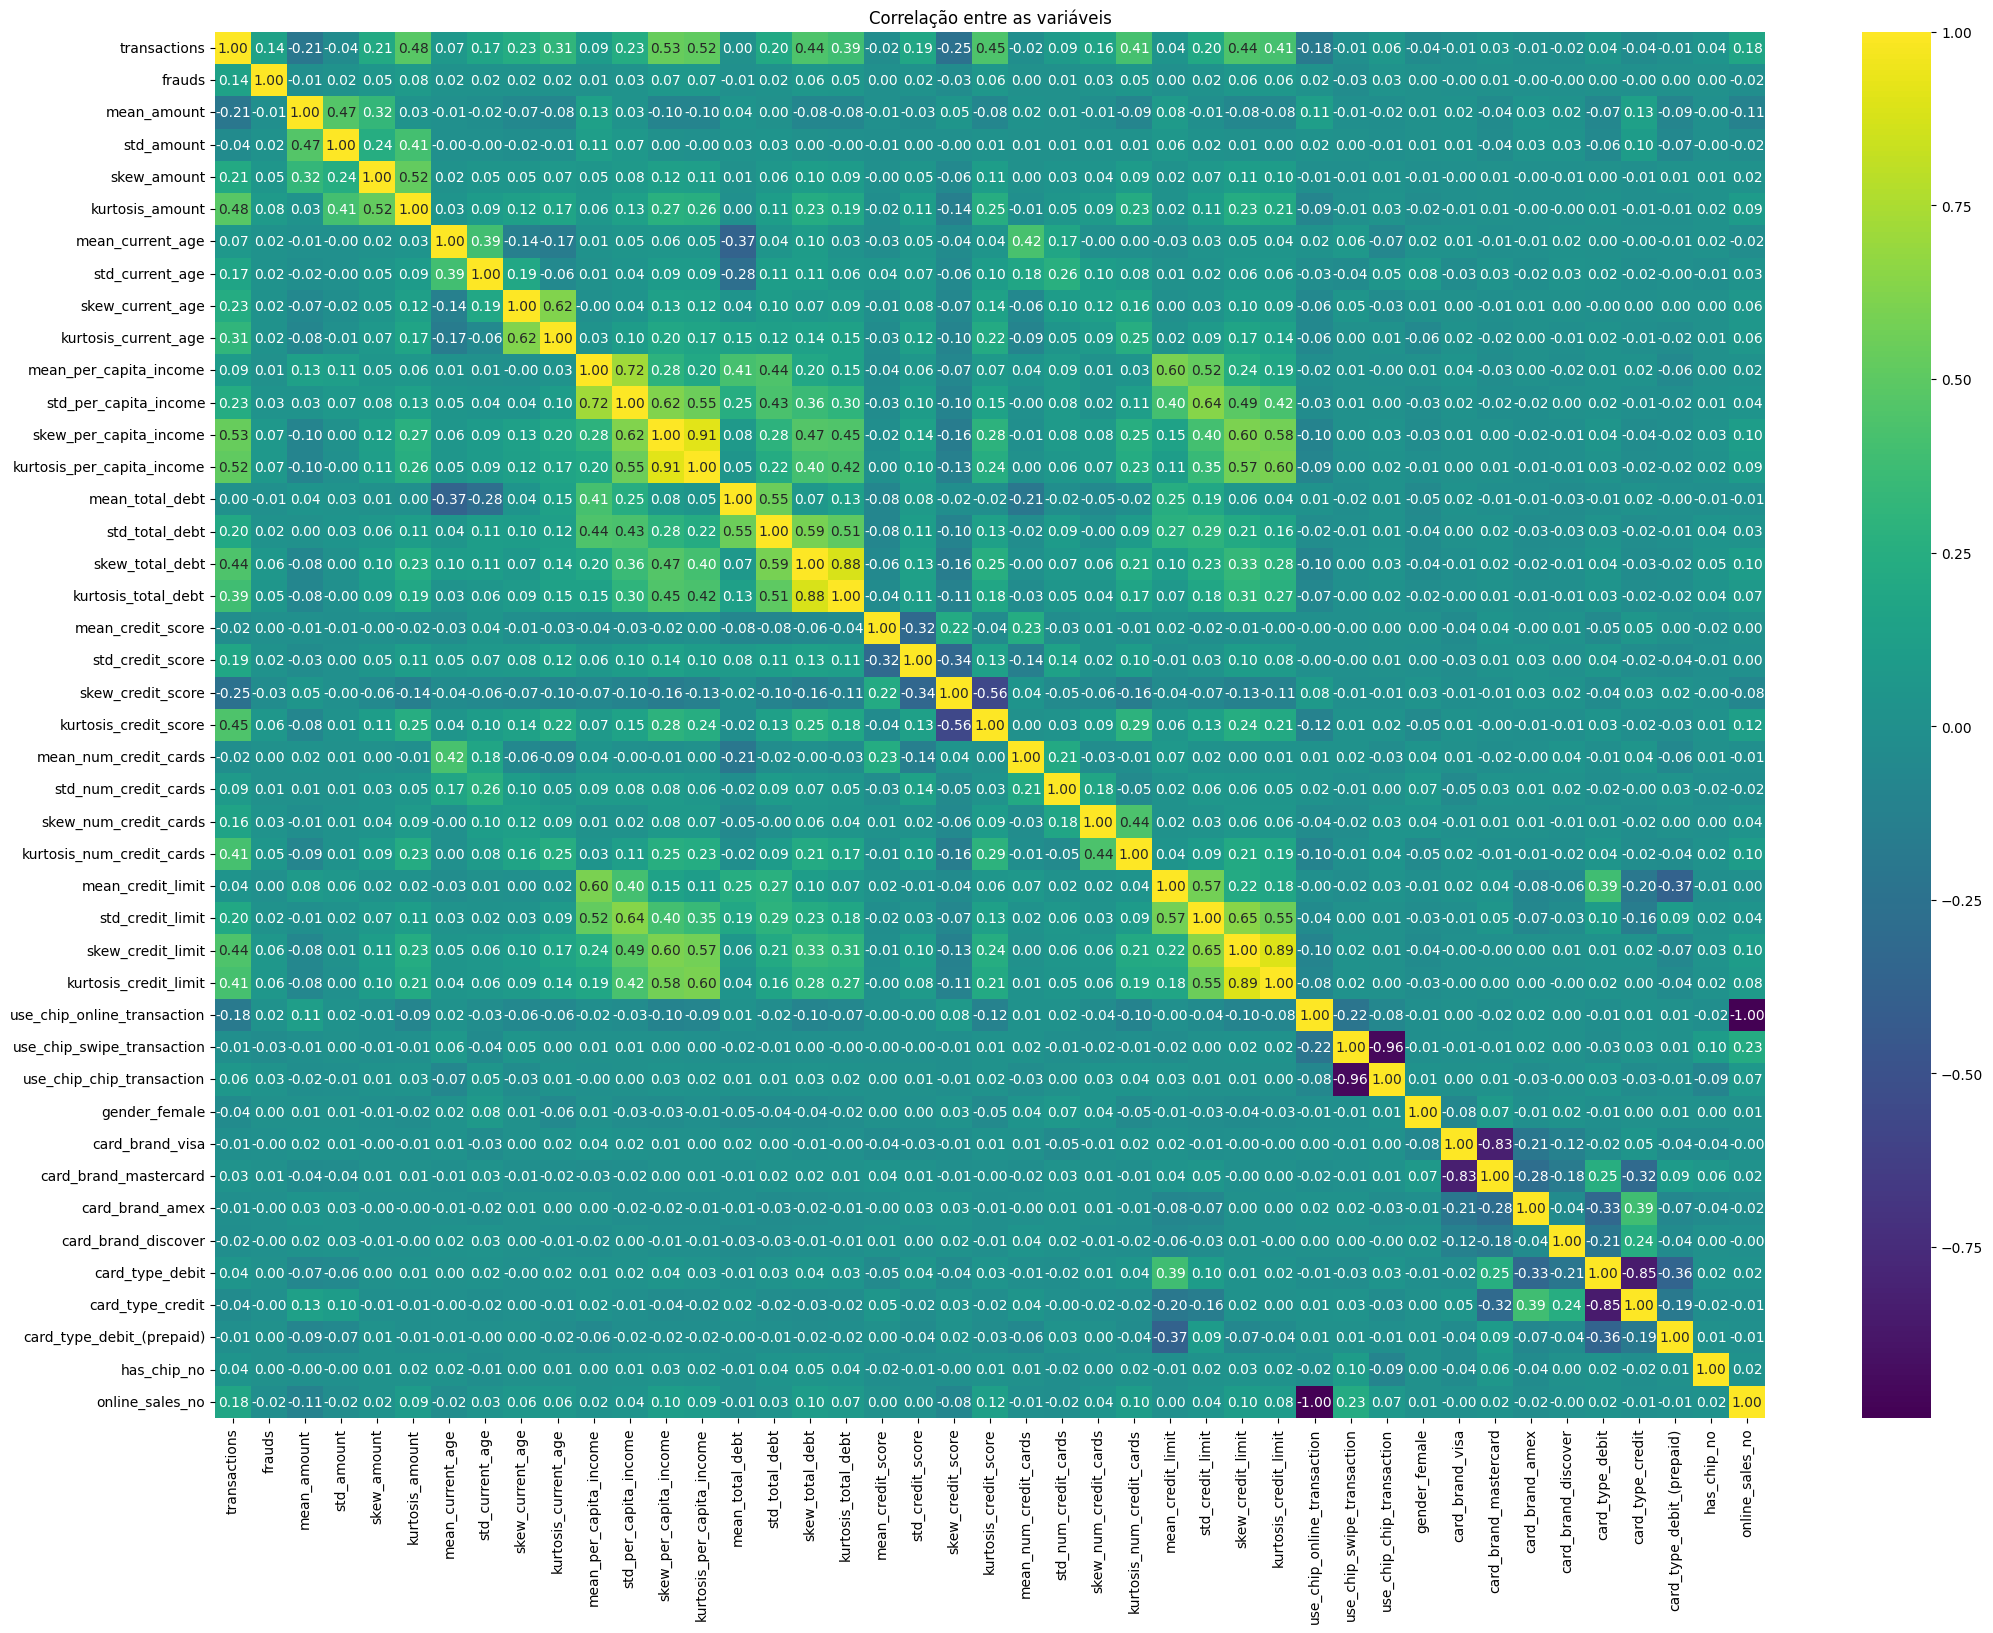

In [14]:
corr = df_model.to_pandas().drop(columns=['date_window']).corr()

plt.figure(figsize=(25,18))
plt.title('Correlação entre as variáveis')

sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')

plt.show()

### Conversão de variável categorica com multiplos valores

#### Análise de proporção das categorias em relação a variavel alvo de fraude

Objetivo: Analisar se seria possível agrupar categorias com menor frequência em uma categoria Outros

In [15]:
df_proportion = df['description'].value_counts(normalize=True).sort('proportion', descending=True)
df_proportion.head()

description,proportion
str,f64
"""Grocery Stores, Supermarkets""",0.119668
"""Miscellaneous Food Stores""",0.10986
"""Service Stations""",0.107137
"""Eating Places and Restaurants""",0.075133
"""Drug Stores and Pharmacies""",0.058037


In [16]:
df_proportion.shape

(108, 2)

In [17]:
df_proportion = df.group_by("description").agg([
    pl.len().alias("transaction_count"),
    pl.col("target").sum().alias("frauds"),
    pl.sum("amount").alias("total_amount"),
]).join(df_proportion, on='description', how='left')

In [18]:
df_proportion.filter(pl.col('proportion') >= 0.01)[['proportion', 'frauds']].sum()

proportion,frauds
f64,i32
0.870067,7315


In [19]:
df_proportion.filter(pl.col('proportion') < 0.01)[['proportion', 'frauds']].sum()

proportion,frauds
f64,i32
0.129933,6017


#### Conversão das categorias em grupos de igual similariedade através de classificação via LLM

In [50]:
def execute_command_llm(data):
  response = azure_client.chat.completions.create(
    messages=[
         {
             "role": "user",
             "content": data
         },
    ],
    model='o1',
    max_completion_tokens=16000
  )
  return json.loads(response.choices[0].message.content.replace('```json', '').replace('```', ''))

In [51]:
prompt = """
Voce é um agente de inteligência artificial especializado em análise de grupos de negócios e com expertise nesse tipo de tarefa.

Sua tarefa será segmentar as categorias disponíveis em <categories></categories> em grupos com base em suas características de forma que esses grupos sejam homogêneos internamente e heterogêneos entre eles.
Utilize os possíveis grupos, já existentes ou não, disponíveis em <groups></groups> para reorganizar essas categorias. Caso necessite crie novos grupos.

OS grupos deverão ter o seguinte formato:
```json
[{\"cluster\":\"Health and Wellbeing\",\"items\":[\"Hospitals\",\"Medical Clinics\",\"Pharmacies\"]}]
```

Garanta que todos os categorias estejam segmentados em grupos.

<categories>
@categories
</categories>

<groups>
@groups
</groups
"""

In [52]:
def segment_categories(categories, groups):
  data = prompt.replace('@categories', str.join('\n', categories)).replace('@groups', str.join('\n', groups))
  return execute_command_llm(data)

In [53]:
unique_categories =  df['description'].unique().to_list()
len(unique_categories)

108

In [54]:
categories_cluster = None
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')

  if os.path.exists('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/categories.json'):
    shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/categories.json','/content/')
    with open('/content/categories.json', 'r') as file:
      categories_cluster = json.load(file)
      print('Categories loaded from drive')
  else:
    print('Categories not found in drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Categories not found in drive


In [55]:
if not categories_cluster:

  categories_to_cluster = unique_categories.copy()

  while len(categories_to_cluster) > 0:
    categories_cluster = segment_categories(
        str.join(';', categories_to_cluster),
        json.dumps(categories_cluster, ensure_ascii=True) if categories_cluster else "[]"
    )

    categories_from_cluster = sum(list(map(lambda x: x['items'], categories_cluster)), [])
    categories_to_cluster = [category for category in unique_categories if category not in categories_from_cluster]

    if categories_to_cluster:
      print(f'There are categories not in clusters: {str.join(", ", categories_to_cluster)}')
  else:
    print('All categories were clustered')

  with open('/content/categories.json', 'w') as file:
      json.dump(categories_cluster, file, ensure_ascii=True)

  if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    shutil.copy('/content/categories.json', '/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/')

All categories were clustered
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
categories_cluster = sum(list(map(lambda x: [dict(category=x['cluster'], description=item) for item in x['items']], categories_cluster)), [])
categories_cluster = pl.DataFrame(categories_cluster)
categories_cluster.head()

category,description
str,str
"""Arts, Entertainment & Recreati…","""Amusement Parks, Carnivals, Ci…"
"""Arts, Entertainment & Recreati…","""Motion Picture Theaters"""
"""Arts, Entertainment & Recreati…","""Theatrical Producers"""
"""Arts, Entertainment & Recreati…","""Betting (including Lottery Tic…"
"""Construction & Contractors""","""Heating, Plumbing, Air Conditi…"


In [59]:
df = df.join(categories_cluster, on='description', how='left')
df.head()

id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,description,target,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web,online_sales,city,country,date_window,category
i64,datetime[ns],i64,i64,f64,str,i64,str,str,f64,str,str,str,i32,i64,i64,i64,i64,str,str,f64,f64,f64,f64,f64,i64,i64,str,str,i64,str,i64,str,i64,f64,str,i64,str,str,str,str,datetime[μs],str
7475327,2010-01-01 00:01:00,1556,2972,-77.0,"""Swipe Transaction""",59935,"""Beulah""","""ND""",58523.0,"""5499""",null,"""Miscellaneous Food Stores""",0,30,67,1989,7,"""Female""","""594 Mountain View Street""",46.8,-100.76,23679.0,48277.0,110153.0,740,4,"""Mastercard""","""Debit (Prepaid)""",5497590243197280,"""07/2022""",306,"""YES""",2,55.0,"""05/2008""",2008,"""No""","""No""","""Beulah""","""United States""",2010-01-01 00:00:00,"""Food & Beverage"""
7475328,2010-01-01 00:02:00,561,4575,14.57,"""Swipe Transaction""",67570,"""Bettendorf""","""IA""",52722.0,"""5311""",null,"""Department Stores""",0,48,67,1971,6,"""Male""","""604 Pine Street""",40.8,-91.12,18076.0,36853.0,112139.0,834,5,"""Mastercard""","""Credit""",5175842699412235,"""12/2024""",438,"""YES""",1,9100.0,"""09/2005""",2015,"""No""","""No""","""Bettendorf""","""United States""",2010-01-01 00:00:00,"""Retail - General & Department"""
7475329,2010-01-01 00:02:00,1129,102,80.0,"""Swipe Transaction""",27092,"""Vista""","""CA""",92084.0,"""4829""",null,"""Money Transfer""",0,49,65,1970,4,"""Male""","""2379 Forest Lane""",33.18,-117.29,16894.0,34449.0,36540.0,686,3,"""Mastercard""","""Debit""",5874992802287595,"""05/2020""",256,"""YES""",1,14802.0,"""01/2006""",2008,"""No""","""No""","""Vista""","""United States""",2010-01-01 00:00:00,"""Financial & Insurance"""
7475332,2010-01-01 00:06:00,848,3915,46.41,"""Swipe Transaction""",13051,"""Harwood""","""MD""",20776.0,"""5813""",null,"""Drinking Places (Alcoholic Bev…",0,51,69,1968,5,"""Male""","""166 River Drive""",38.86,-76.6,33529.0,68362.0,96182.0,711,2,"""Visa""","""Debit""",4354185735186651,"""01/2020""",120,"""YES""",1,19113.0,"""07/2009""",2014,"""No""","""No""","""Harwood""","""United States""",2010-01-01 00:00:00,"""Food & Beverage"""
7475333,2010-01-01 00:07:00,1807,165,4.81,"""Swipe Transaction""",20519,"""Bronx""","""NY""",10464.0,"""5942""",null,"""Book Stores""",0,47,65,1972,12,"""Female""","""14780 Plum Lane""",40.84,-73.87,25537.0,52065.0,98613.0,828,5,"""Mastercard""","""Debit (Prepaid)""",5207231566469664,"""03/2014""",198,"""YES""",1,89.0,"""01/2008""",2015,"""No""","""No""","""Bronx""","""United States""",2010-01-01 00:00:00,"""Retail - Specialty"""


In [60]:
df.filter(df['category'].is_null())

id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,description,target,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web,online_sales,city,country,date_window,category
i64,datetime[ns],i64,i64,f64,str,i64,str,str,f64,str,str,str,i32,i64,i64,i64,i64,str,str,f64,f64,f64,f64,f64,i64,i64,str,str,i64,str,i64,str,i64,f64,str,i64,str,str,str,str,datetime[μs],str


#### Aplicação da conversão das categorias agrupadas em grupos percentuais para os registros agrupados

In [61]:
for column in ['category']:
  df_field = convert_categorical_to_percent(df, column, 'date_window')
  df_model = df_model.join(df_field, on='date_window', how='left')
df_model.head(10)

date_window,transactions,frauds,mean_amount,std_amount,skew_amount,kurtosis_amount,mean_current_age,std_current_age,skew_current_age,kurtosis_current_age,mean_per_capita_income,std_per_capita_income,skew_per_capita_income,kurtosis_per_capita_income,mean_total_debt,std_total_debt,skew_total_debt,kurtosis_total_debt,mean_credit_score,std_credit_score,skew_credit_score,kurtosis_credit_score,mean_num_credit_cards,std_num_credit_cards,skew_num_credit_cards,kurtosis_num_credit_cards,mean_credit_limit,std_credit_limit,skew_credit_limit,kurtosis_credit_limit,use_chip_online_transaction,use_chip_swipe_transaction,use_chip_chip_transaction,gender_female,card_brand_visa,card_brand_mastercard,card_brand_amex,card_brand_discover,card_type_debit,card_type_credit,card_type_debit_(prepaid),has_chip_no,online_sales_no,category_transportation_&_logistics,category_financial_&_insurance,category_food_&_beverage,category_retail_-_general_&_department,category_retail_-_specialty,category_government_&_utilities,category_technology_&_telecommunications,"category_arts,_entertainment_&_recreation",category_travel_&_hospitality,category_professional_&_business_services,category_health_&_medical,category_retail_-_clothing_&_accessories,category_sports_&_recreation,category_construction_&_contractors,category_retail_-_home_&_garden,category_manufacturing_&_industrial,category_personal_services
datetime[μs],u32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2010-01-01 00:00:00,6,0,15.875,52.737742,-0.760483,-0.139116,46.833333,8.841191,-1.241314,0.444023,21897.166667,7198.264219,0.522412,-0.861983,93656.666667,28711.635012,-1.594374,0.842529,763.5,61.29845,0.001812,-1.536333,4.0,1.264911,-0.649519,-1.125,7200.833333,8439.396078,0.381076,-1.520432,0.17,0.83,0.0,0.33,0.17,0.83,0.0,0.0,0.33,0.17,0.5,0.0,0.83,0.17,0.17,0.33,0.17,0.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-01 00:15:00,4,0,22.2625,22.245049,0.012927,-1.980469,49.5,16.663333,-0.134765,-1.560644,24534.0,1301.539345,0.354425,-1.461239,60605.5,59834.776479,-0.01997,-1.967191,724.5,24.310492,-0.830693,-0.974824,4.25,0.957427,-0.493382,-1.371901,12608.5,13718.592311,0.010111,-1.972188,0.0,1.0,0.0,0.25,0.75,0.25,0.0,0.0,0.75,0.0,0.25,0.25,1.0,0.25,0.0,0.5,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-01 00:30:00,10,0,34.644,45.188942,-0.779579,0.46044,48.6,4.993329,-0.461034,0.602038,21695.6,6709.572916,0.674351,-0.812142,56477.3,48226.48252,0.235514,-1.124026,700.3,63.4421,-1.464207,2.09804,3.8,1.316561,-0.541972,0.607495,19807.9,6338.6096,0.114952,-1.629159,0.2,0.8,0.0,0.5,0.2,0.8,0.0,0.0,0.6,0.4,0.0,0.0,0.8,0.6,0.1,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-01 00:45:00,6,0,15.388333,14.262798,0.910151,-0.471315,70.5,18.251027,0.262932,-1.015413,19808.166667,3592.733245,0.927645,-0.439468,40391.666667,51012.043302,0.59751,-1.399093,772.166667,41.421814,-0.0949,-1.491414,5.333333,1.632993,-0.279508,-1.365,17533.666667,11039.367893,-0.713338,-1.100947,0.17,0.83,0.0,0.5,0.33,0.5,0.17,0.0,0.67,0.17,0.17,0.0,0.83,0.17,0.0,0.67,0.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-01 01:00:00,6,0,101.018333,97.728056,0.816882,-0.48396,54.5,9.648834,0.573632,-1.012784,26342.666667,15248.228011,1.251008,0.412107,67331.166667,35267.904737,0.400987,-1.525858,730.333333,83.946809,0.055991,-1.513659,3.833333,1.47196,-0.519038,-1.56071,23233.333333,20657.262681,1.339601,0.337726,0.5,0.5,0.0,0.67,0.17,0.83,0.0,0.0,0.67,0.33,0.0,0.0,0.5,0.17,0.0,0.33,0.0,0.0,0.33,0.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-01 01:15:00,5,0,4.61,53.67871,-0.468739,-0.482601,43.6,7.402702,-0.754216,-0.771215,23935.4,3065.888664,0.013807,-0.528075,81437.8,28100.092281,1.039823,-0.491354,754.0,56.178288,1.098869,-0.206714,3.0,1.0,0.0,-1.75,14693.8,4012.619369,-0.062165,-1

### Análise de correlação do dataset completo

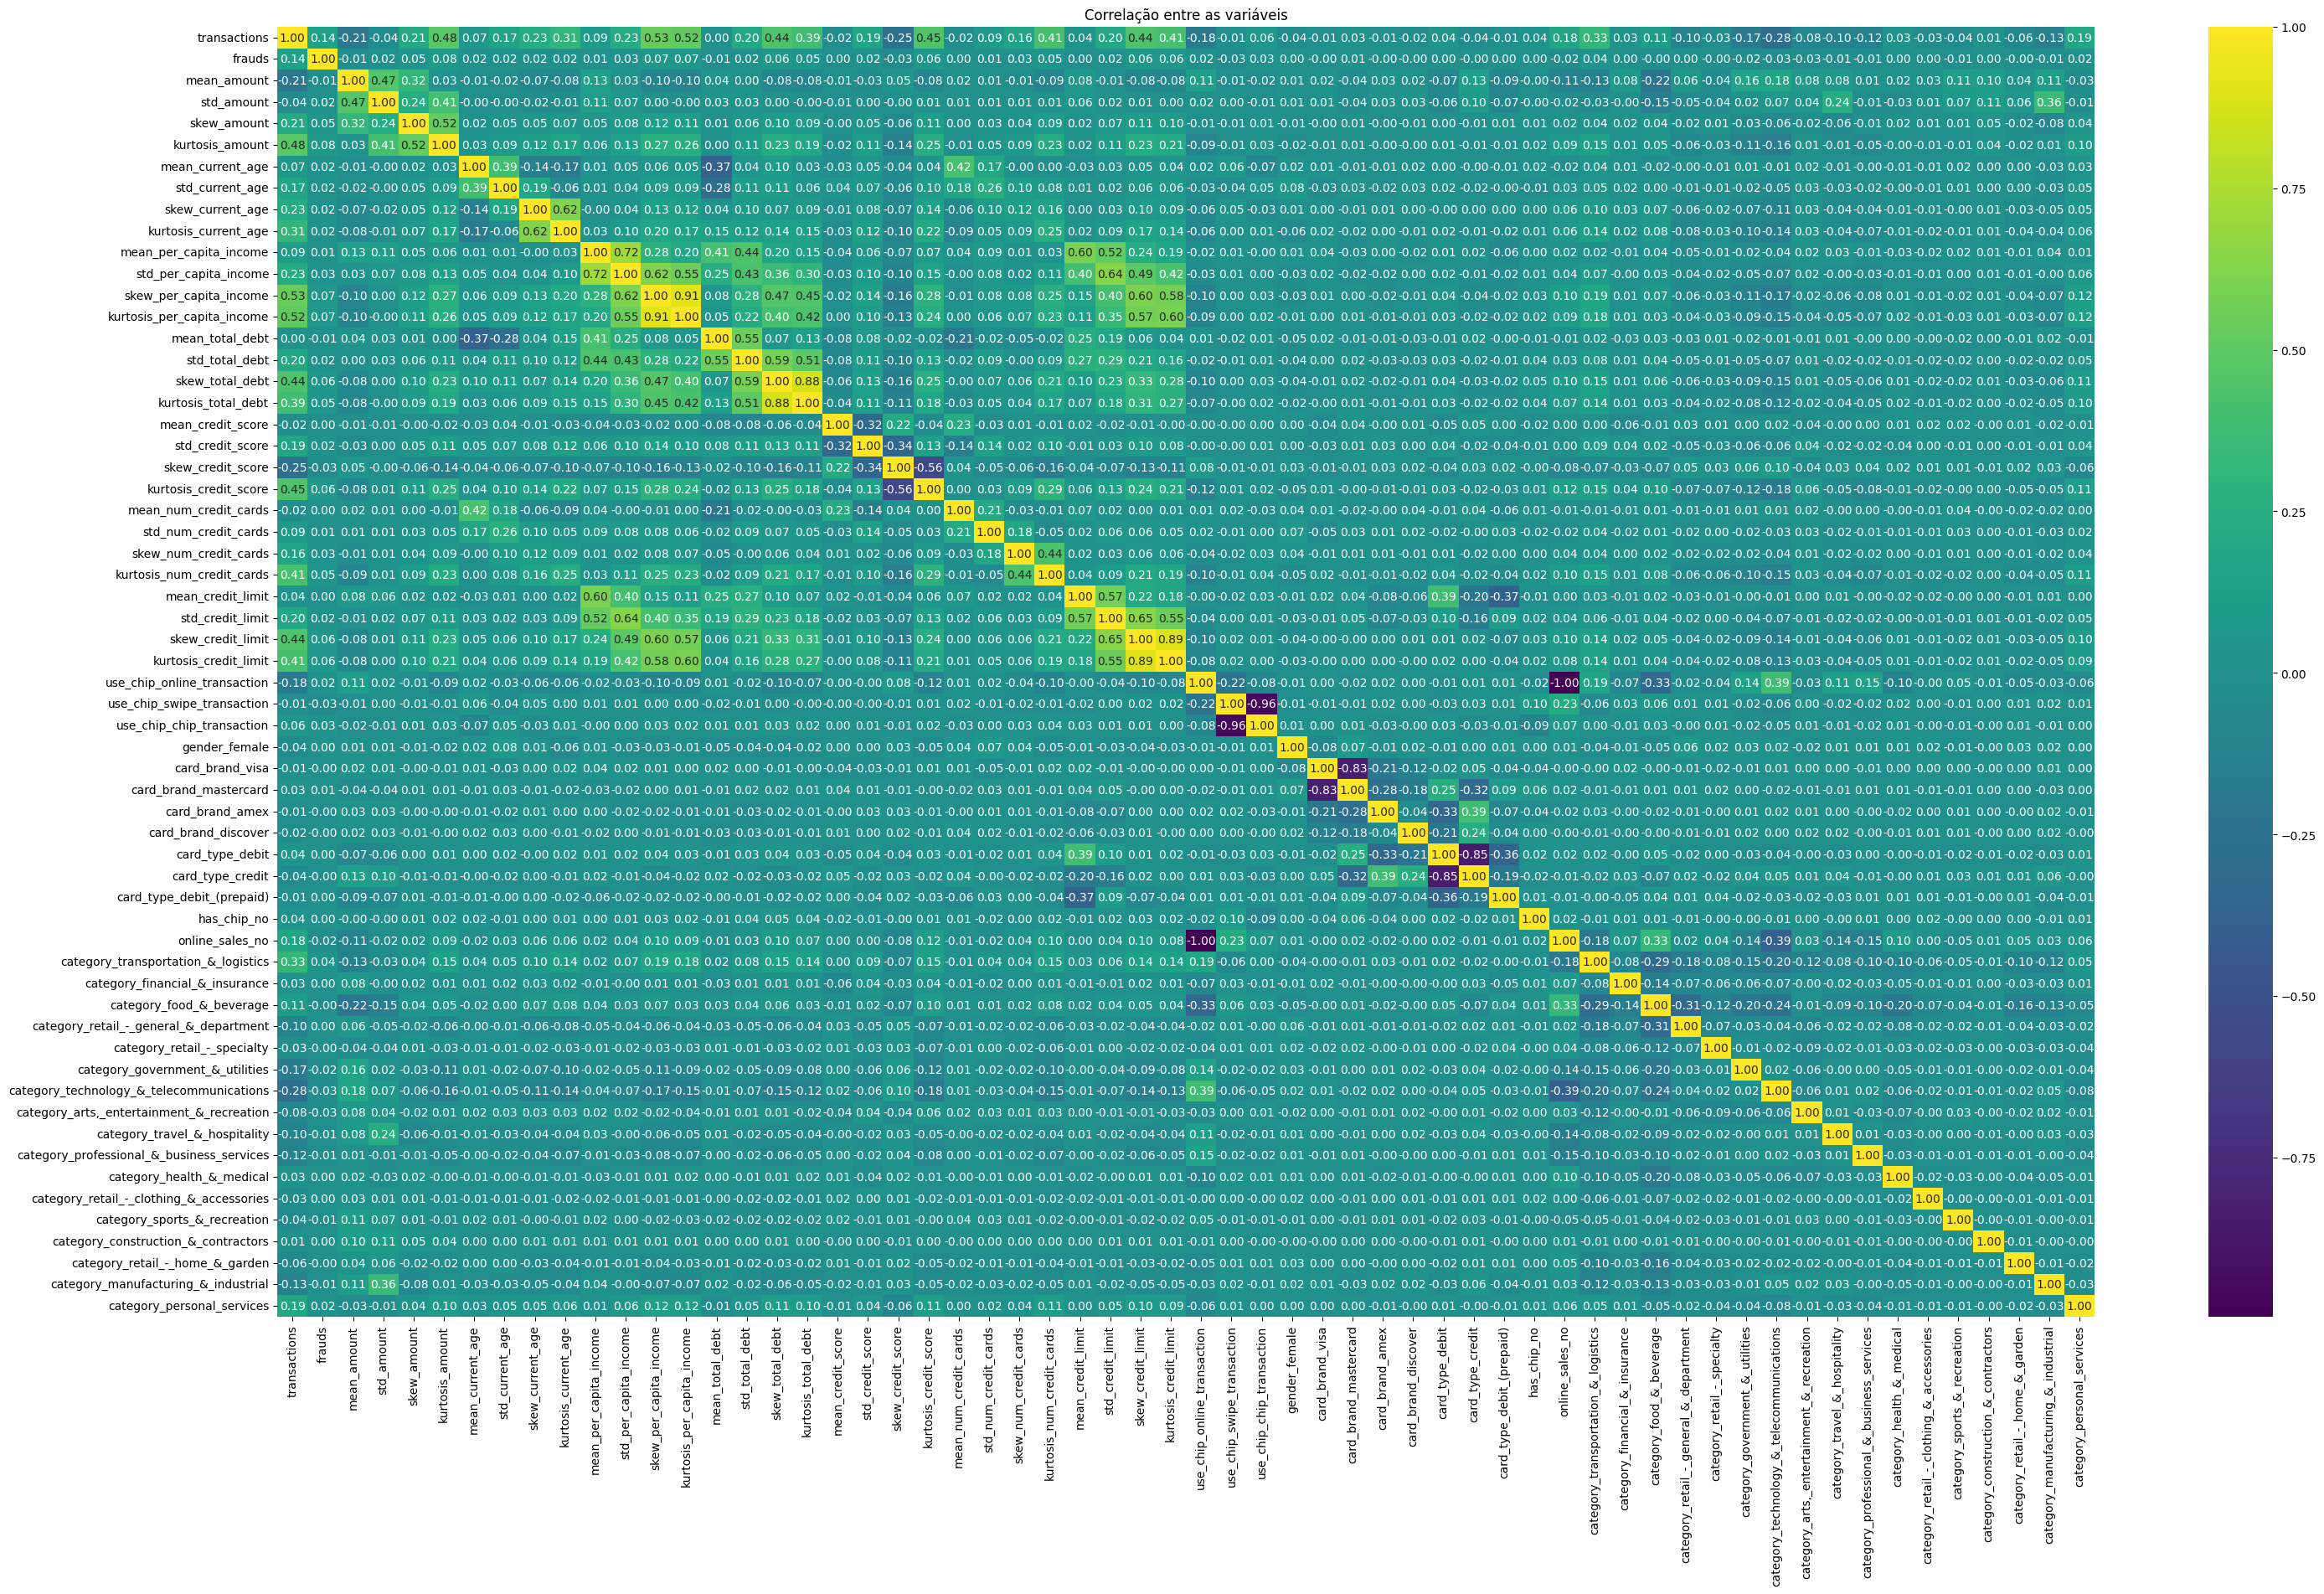

In [62]:
corr = df_model.to_pandas().drop(columns=['date_window']).corr()

plt.figure(figsize=(35,20))
plt.title('Correlação entre as variáveis')

sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')

plt.show()

## Persistência do novo dataset

In [73]:
df_model.columns = [str(column).replace('-', '_').replace('&_', '').replace('__', '').replace('___', '').replace(',', '') for column in df_model.columns]

In [74]:
df_model.write_parquet('./datasets/transactions_features.parquet', use_pyarrow=True)

In [75]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')

  shutil.copy('./datasets/transactions_features.parquet', '/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
